In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import model_selection, preprocessing
import seaborn as sns

In [2]:
data_variant = pd.read_csv("./training/training_variants")
data_txt = pd.read_csv("./training/training_text", sep='\|\|', names=["ID","TEXT"], skiprows=1, engine='python')

In [3]:
data_variant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [4]:
data_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [5]:
data_variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


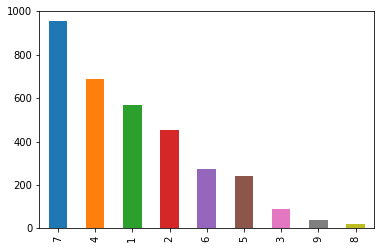

In [6]:
variants = data_variant['Class'].value_counts()

variants.plot.bar()

([<matplotlib.axis.YTick at 0x1e3afd7a780>,
 <a list of 9 Text yticklabel objects>)

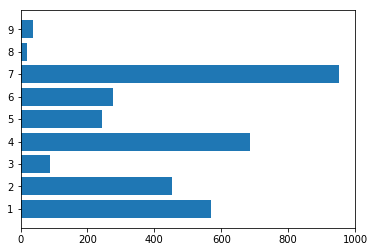

In [7]:
plt.barh(variants.index, variants.values)
plt.yticks(variants.index)

In [8]:
data_txt.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
data_variant.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


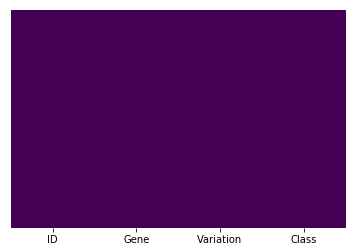

In [10]:
sns.heatmap(data_variant.isnull(),cbar=False, yticklabels=False,cmap='viridis')

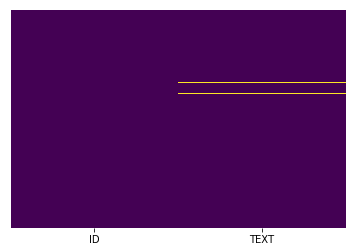

In [11]:
sns.heatmap(data_txt.isnull(),cbar=False, yticklabels=False,cmap='viridis')

In [12]:
data_txt[data_txt.isnull().any(axis=1)].count()

ID      5
TEXT    0
dtype: int64

ML Problem statement :
1. We have to predict the cancer class (1-9) based on the type of mutation a person has. Its a multiclass classification problem.
2. Errors are very bad in medical world and it is better for doctors to provide reasoning why a person falls under one of 9 categories of cancer. 
    a) Talking in probabilistic term will be more intutive here
    b) Interpretability of results (why perticular class) is also necessary
3. As we are more focussed towards accuracy , we can allow some expensive operations/algorithms to do calculation inorder to achive desired accuracy.

In [13]:
# from data_txt, we would like to process research papers, that is text field
# we want to remove stop words, using nltk 
from nltk.corpus import stopwords
import re

In [14]:
def data_txt_preprocess(text, ind, col):
    # remove integers from text
    if type(text) is not int:
        string = ''
        
        # replacing all special characters with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', str(text))
        
        # replace multiple spaces with single space
        text = re.sub('\s+',' ', str(text))
        
        text = text.lower()
        stop_words = set(stopwords.words('english')) 
        for word in text.split():
            if word not in stop_words:
                string+=word + " "
                
        data_txt.loc[ind, col] = string

In [15]:
# call the above function and preprocess all the text data
for index, row in data_txt.iterrows():
    if type(row['TEXT']) is str:
        data_txt_preprocess(row['TEXT'], index,'TEXT')

data_txt.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [16]:
# merge two data
result = pd.merge(data_variant, data_txt, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [17]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [18]:
# impudate TEXT field with gene and variation name
result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] + " " + result['Variation'] 

In [19]:
# check for null values again.
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


# Create train, test and validation set

In [20]:
# Before splitting , lets remove all spaces in Gene and Variations columns
result.Gene = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+','_')

In [21]:
X = result
y = result['Class']
X.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print("Train size: ", len(y_train))
print("Cross validation size: ", len(y_cv))
print("Test data size: ", len(y_test))

Train size:  2124
Cross validation size:  532
Test data size:  665


In [23]:
# check if all class examples are properly distributed in all three train , CV and test parts, otherwise it will be a problem
train_class_distribution = y_train.value_counts()
validation_class_distribution = y_cv.value_counts()
test_class_distribution = y_test.value_counts()

print(train_class_distribution)

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64


In [24]:
y_train.value_counts().loc[2]

289

In [25]:
# calculate %age class distribution in each data set
percent_dict = {}
for i in range(1,10):
    train_dist = np.round_(100*y_train.value_counts().loc[i]/y.value_counts().loc[i])
    test_dist = np.round_(100*y_test.value_counts().loc[i]/y.value_counts().loc[i])
    cv_dist = np.round_(100*y_cv.value_counts().loc[i]/y.value_counts().loc[i])
    percent_dict[i] = [train_dist, cv_dist, test_dist]
    
    
percent_dict
    

{1: [64.0, 16.0, 20.0],
 2: [64.0, 16.0, 20.0],
 3: [64.0, 16.0, 20.0],
 4: [64.0, 16.0, 20.0],
 5: [64.0, 16.0, 20.0],
 6: [64.0, 16.0, 20.0],
 7: [64.0, 16.0, 20.0],
 8: [63.0, 16.0, 21.0],
 9: [65.0, 16.0, 19.0]}

In [26]:
percent_df = pd.DataFrame.from_dict(percent_dict, orient='index')
percent_df.columns = ['Train','CV','Test']

percent_df

#fig, ax = plt.subplots(1,3)
#ax[0].bar(percent_df.index, percent_df['Train'])

,Train,CV,Test
1,64.0,16.0,20.0
2,64.0,16.0,20.0
3,64.0,16.0,20.0
4,64.0,16.0,20.0
5,64.0,16.0,20.0
6,64.0,16.0,20.0
7,64.0,16.0,20.0
8,63.0,16.0,21.0
9,65.0,16.0,19.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.


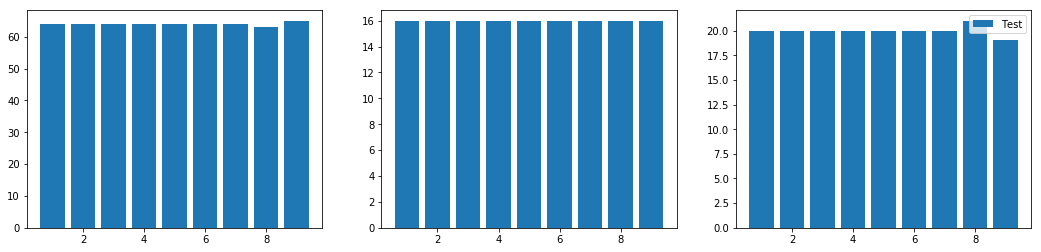

In [27]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(18)
for i in range(0,3):
    ax[i].bar(percent_df.index, percent_df.iloc[:,i], label = percent_df.columns[i])
    plt.legend()


## Building a random model (worst model) to set a performance bench mark

### perfomance matrics -  Log loss function, = -1/n * Sum (y*log(p) + (1-y)*log(1-p))

In [28]:
# Generate random probabilities and calculate log loss on CV and Test data set
CV_data_len = X_cv.shape[0]
Test_data_len = X_test.shape[0]
from sklearn.metrics import log_loss

In [29]:
# for cross validattion
cv_predicted_y = np.zeros((CV_data_len,9))
for i in range(CV_data_len):
    rand_prob = np.random.rand(1,9)
    cv_predicted_y[i] = (rand_prob/sum(sum(rand_prob)))[0]
print("CV log loss : ", log_loss(y_cv,cv_predicted_y))

CV log loss :  2.4962937400746164


In [30]:
# for test data set
test_predicted_y = np.zeros((Test_data_len,9))
for i in range(Test_data_len):
    rand_prob = np.random.rand(1,9)
    test_predicted_y[i] = (rand_prob/sum(sum(rand_prob)))[0]
print("Test prediction log loss : ", log_loss(y_test,test_predicted_y))

Test prediction log loss :  2.4354407307589647


In [31]:
worst_predicted = np.argmax(test_predicted_y, axis=1)
worst_predicted

array([6, 5, 0, 1, 3, 5, 6, 3, 6, 4, 5, 4, 3, 3, 6, 5, 8, 8, 8, 8, 2, 6,
       2, 1, 0, 5, 0, 8, 7, 0, 2, 2, 2, 2, 3, 0, 7, 6, 3, 3, 0, 7, 6, 3,
       4, 1, 1, 2, 1, 8, 6, 2, 2, 4, 7, 2, 6, 6, 6, 6, 0, 4, 1, 6, 5, 3,
       8, 0, 5, 4, 5, 0, 1, 8, 4, 2, 4, 0, 2, 3, 8, 1, 5, 4, 1, 2, 0, 2,
       0, 0, 0, 7, 3, 6, 5, 0, 8, 8, 7, 3, 0, 4, 5, 7, 5, 7, 7, 0, 7, 1,
       6, 3, 1, 8, 8, 8, 7, 7, 3, 6, 3, 6, 5, 7, 3, 0, 6, 6, 2, 0, 3, 4,
       3, 7, 6, 7, 7, 0, 7, 7, 8, 6, 5, 6, 7, 4, 5, 1, 3, 3, 7, 1, 3, 8,
       6, 7, 5, 0, 5, 3, 4, 4, 8, 7, 8, 8, 0, 5, 0, 1, 6, 4, 2, 2, 0, 7,
       8, 5, 1, 1, 0, 1, 1, 6, 2, 6, 6, 3, 3, 1, 2, 4, 1, 0, 2, 7, 1, 6,
       8, 1, 0, 5, 3, 3, 6, 2, 1, 2, 2, 5, 8, 6, 8, 5, 2, 3, 6, 0, 2, 4,
       3, 7, 0, 0, 4, 2, 1, 1, 3, 8, 2, 4, 1, 6, 7, 4, 3, 5, 4, 4, 1, 5,
       5, 8, 3, 4, 2, 7, 8, 7, 1, 4, 6, 8, 1, 4, 3, 7, 2, 2, 6, 5, 3, 3,
       4, 4, 0, 2, 7, 1, 8, 8, 2, 0, 5, 5, 7, 0, 7, 8, 5, 5, 4, 6, 2, 0,
       6, 7, 4, 1, 7, 3, 1, 1, 4, 2, 5, 7, 1, 2, 1,

In [32]:
worst_predicted = worst_predicted + 1

In [33]:
# calculate confusion matrix, precision and recall

from sklearn.metrics import confusion_matrix, accuracy_score

C = confusion_matrix(y_test, worst_predicted)
print("Worst model accuracy is: ", accuracy_score(y_test, worst_predicted))
print(C)

Worst model accuracy is:  0.12481203007518797
[[17  7 20  8  7 13 15 12 15]
 [ 8 10 15  8 11 12 14  8  5]
 [ 3  2  3  1  2  2  2  2  1]
 [18 22 11 18 11  9 14 23 11]
 [ 4  4  5  8  8  4  6  7  2]
 [ 8  6  5  7  9  6  6  3  5]
 [24 17 24 21 22 20 20 23 20]
 [ 0  1  1  1  0  0  0  1  0]
 [ 1  1  1  1  2  0  1  0  0]]


Text(159,0.5,'Actual Classes')

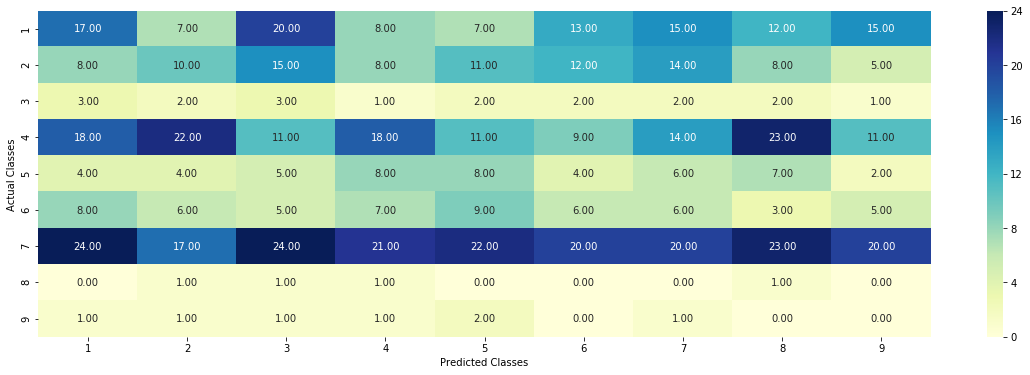

In [34]:
classes = [n for n in range(1,10)]
plt.figure(figsize=(20,6))
sns.heatmap(C, fmt="0.2f", xticklabels=classes, yticklabels=classes, cmap='YlGnBu', annot=True)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

In [35]:
# precision metics
# out of all prediction for a perticular class , what portion is correct
P = C/C.sum(axis = 0)

Text(159,0.5,'Actual Classes')

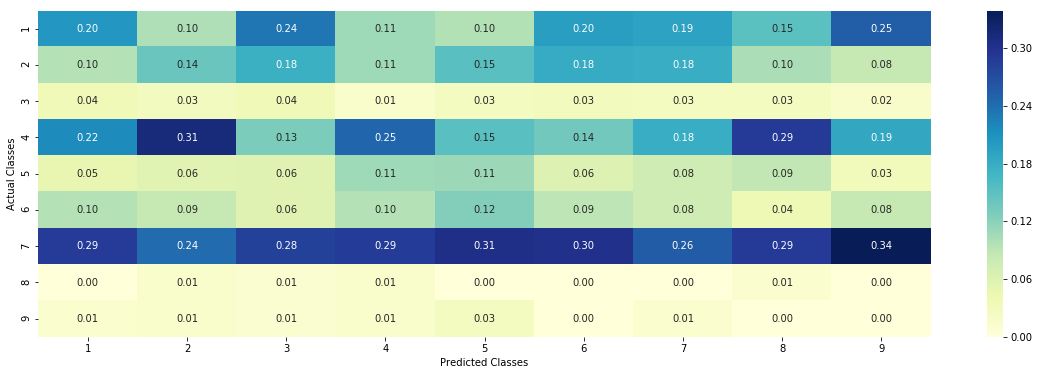

In [36]:

plt.figure(figsize=(20,6))
sns.heatmap(P, fmt="0.2f", xticklabels=classes, yticklabels=classes, cmap='YlGnBu', annot=True)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

In [37]:
# Recall
# Out of all those belogs to one class, what portion is predicted correctly
R = (C.T / C.sum(axis=1)).T

Text(159,0.5,'Actual Classes')

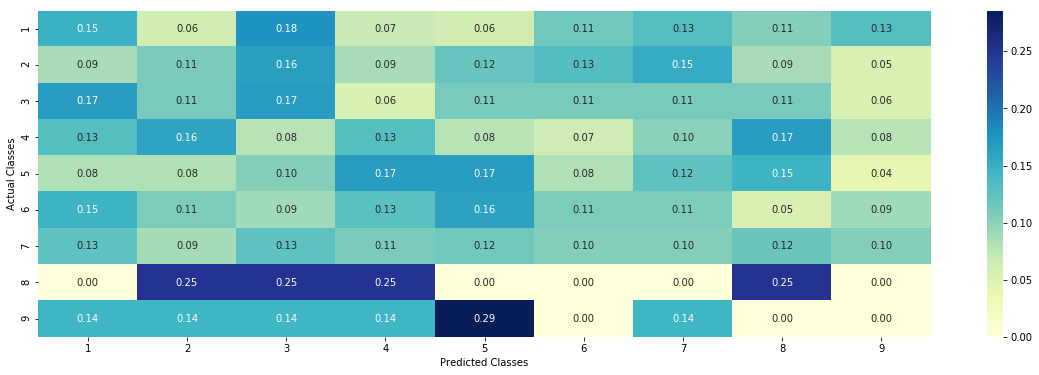

In [38]:

plt.figure(figsize=(20,6))
sns.heatmap(R, fmt="0.2f", xticklabels=classes, yticklabels=classes, cmap='YlGnBu', annot=True)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")

## Evaluate Gene column

In [39]:
unique_genes = X_train['Gene'].value_counts()
print("count : ", unique_genes.shape[0])
unique_genes.head(10)

count :  237


BRCA1     169
TP53      109
EGFR       87
BRCA2      81
PTEN       80
KIT        63
BRAF       59
ALK        47
ERBB2      47
PDGFRA     36
Name: Gene, dtype: int64

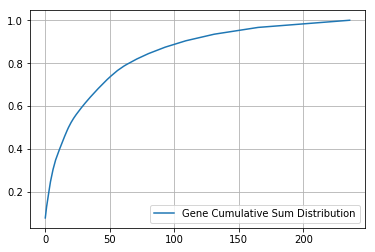

In [40]:
# plot a cumulative graph on gene column to see distribution
# first normalize the counts
s = sum(unique_genes.values)
h = unique_genes.values / s
c_sum = np.cumsum(h)
plt.plot(c_sum, label = "Gene Cumulative Sum Distribution")
plt.grid()
plt.legend()

#### We can see from above graph that more than 75% of data are for top 50 genes
## Lets deal with this categorical data now

### There are two methods -
#### One hot Encoding - 
#### Responce Encoding (Mean Imputation)

There is much more problem with one hot encoding here as unique categories are 236 in this case. Lets see both -

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
gene_vectorizer = CountVectorizer()

In [42]:
train_gene_feature_onehotencoding = gene_vectorizer.fit_transform(X_train['Gene'])
cv_gene_feature_onehotencoding = gene_vectorizer.transform(X_cv['Gene'])
test_gene_feature_onehotencoding = gene_vectorizer.transform(X_test['Gene'])

cv_gene_feature_onehotencoding.shape

(532, 236)

In [43]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh

One hot encoding will create too many columns and increase dimentionality of dataset. Models like Random forest will not perform better with high dimentional data. However dimentionality is fine for Linear/Logistic Regression and SVM like models.

## Responce Encoding with Laplas smooting

In [44]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [45]:
X_train.head()

,ID,Gene,Variation,Class,TEXT
1518,1518,ALK,I1171N,7,era personalized medicine understanding molecu...
652,652,CDKN2A,M53I,4,inherited mutations affecting ink4a arf locus ...
2932,2932,NFE2L2,W24S,7,nrf2 nuclear factor erythroid 2 nf e2 related ...
575,575,SMAD3,P336S,4,activation canonical tgf signaling pathway pro...
2008,2008,MAP2K1,Q58_E62del,7,histiocytic neoplasms clonal hematopoietic dis...


In [46]:
# Response encoding of gene column
# Alpha is used for laplas smoothing
alpha = 1

train_gene_feature_responseEncoding = np.array(get_gv_feature(alpha, 'Gene', X_train))
cv_gene_feature_responseEncoding = np.array(get_gv_feature(alpha, 'Gene', X_cv))
test_gene_feature_responseEncoding = np.array(get_gv_feature(alpha, 'Gene', X_test))

train_gene_feature_responseEncoding.shape

(2124, 9)

### How good this gene feature is to predict the classes
Lets fit it to a model logistic regression and check if it produce accuracy better than my worst model

In [47]:
alpha = [10**x for x in range(-5,1)]  # testing pperfomance for different alpha value - hyper paratemer

In [48]:
# Use a SGD classifier
# and calibrated classifier to get the results in term of probabilities (sum of all = 1)
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

cv_log_error_array = []
for i in alpha:
    
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotencoding, y_train)
    
    sigmoid_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sigmoid_clf.fit(train_gene_feature_onehotencoding, y_train)
    predict_sig_y = sigmoid_clf.predict_proba(cv_gene_feature_onehotencoding)
    cv_log_error_array.append(log_loss(y_cv, predict_sig_y, labels = clf.classes_, eps=1e-15))
    print(" for value of alpha {} log loss is {}".format(i, log_loss(y_cv, predict_sig_y, labels = clf.classes_, eps=1e-15)))
    


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

 for value of alpha 1e-05 log loss is 1.3878873641783107
 for value of alpha 0.0001 log loss is 1.2033771427265416


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

 for value of alpha 0.001 log loss is 1.224995204428005


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

 for value of alpha 0.01 log loss is 1.3505317221317108


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

 for value of alpha 0.1 log loss is 1.4546999889788073


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

 for value of alpha 1 log loss is 1.4986085434573797


In [49]:
cv_gene_feature_onehotencoding.shape

(532, 236)

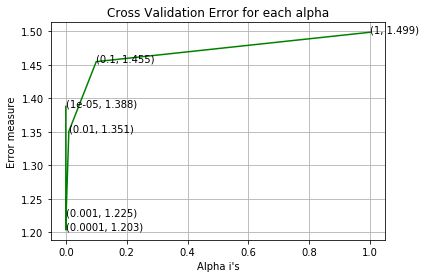

In [50]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
# for annotation
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [51]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotencoding, y_train)
sigmoid_clf = CalibratedClassifierCV(clf, method="sigmoid")
sigmoid_clf.fit(train_gene_feature_onehotencoding, y_train)

predict_sig_y = sigmoid_clf.predict_proba(train_gene_feature_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_sig_y, labels=clf.classes_, eps=1e-15))
predict_sig_y = sigmoid_clf.predict_proba(cv_gene_feature_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_sig_y, labels=clf.classes_, eps=1e-15))
predict_sig_y = sigmoid_clf.predict_proba(test_gene_feature_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_sig_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.0454008178850782
For values of best alpha =  0.0001 The cross validation log loss is: 1.2033771427265416
For values of best alpha =  0.0001 The test log loss is: 1.2270627987745473


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Now lets check how many values are overlapping between train, test or between CV and train

In [52]:
test_coverage = X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage = X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

In [53]:
print('1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

1. In test data 648 out of 665 : 97.44360902255639
2. In cross validation data 517 out of  532 : 97.18045112781954


## Evaluating Variation column

In [54]:
unique_variation = X_train['Variation'].value_counts()
unique_variation.head()

Truncating_Mutations    64
Deletion                47
Amplification           47
Fusions                 21
Overexpression           4
Name: Variation, dtype: int64

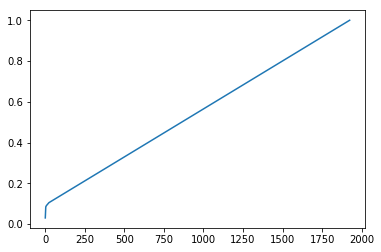

In [55]:
## Cumulative Graph
s = sum(unique_variation.values)
h = unique_variation.values/s
c = np.cumsum(h)

plt.plot(c)

#### one hot encoding for variation

In [56]:
variation_vectorizer = CountVectorizer()
train_variation_onehotencoding = variation_vectorizer.fit_transform(X_train['Variation'])
cv_variation_onehotencoding = variation_vectorizer.transform(X_cv['Variation'])
test_variation_onehotencoding = variation_vectorizer.transform(X_test['Variation'])

In [57]:
train_variation_onehotencoding.shape

(2124, 1957)

### Responce encoding for variation column

In [58]:
alpha = 1

train_variation_responseencoding = np.array(get_gv_feature(alpha, 'Variation', X_train))
test_variation_responseencoding = np.array(get_gv_feature(alpha, 'Variation', X_test))
cv_variation_responseencoding = np.array(get_gv_feature(alpha, 'Variation', X_cv))

In [59]:
train_variation_responseencoding.shape

(2124, 9)

### Lets build a model with variation column only and see if this feature is important

In [60]:
# hyperparameter
alpha = [10**x for x in range(-5,1)]

In [61]:
# SGD classifier for model
# Calibrated classifier to get result in probability terms - sigmoid
cv_log_error_array = []
for i in alpha:
    
    clf = SGDClassifier(alpha=1, loss='log', penalty='l2', random_state=42)
    clf.fit(train_variation_onehotencoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_variation_onehotencoding, y_train)
    predicted_y = sig_clf.predict_proba(cv_variation_onehotencoding)
    
    cv_log_error_array.append(log_loss(y_cv, predicted_y, labels=clf.classes_))
    print("CV log loss for alpha: ", i,"is : ",log_loss(y_cv, predicted_y, labels=clf.classes_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

CV log loss for alpha:  1e-05 is :  1.7031561272905307


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

CV log loss for alpha:  0.0001 is :  1.7031561272905307


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

CV log loss for alpha:  0.001 is :  1.7031561272905307


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


CV log loss for alpha:  0.01 is :  1.7031561272905307


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

CV log loss for alpha:  0.1 is :  1.7031561272905307
CV log loss for alpha:  1 is :  1.7031561272905307


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

In [62]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], loss='log', penalty='l2', random_state=42)
clf.fit(train_variation_onehotencoding, y_train)
    
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_variation_onehotencoding, y_train)


predicted_y = sig_clf.predict_proba(train_variation_onehotencoding)
print(" log loss for training data , with best alpha:", alpha[best_alpha], "is: ",log_loss(y_train, predicted_y, labels=clf.classes_))
    
predicted_y = sig_clf.predict_proba(cv_variation_onehotencoding)
print(" log loss for cv data , with best alpha:", alpha[best_alpha], "is: ",log_loss(y_cv, predicted_y, labels=clf.classes_))

predicted_y = sig_clf.predict_proba(test_variation_onehotencoding)
print(" log loss for test data , with best alpha:", alpha[best_alpha], "is: ",log_loss(y_test, predicted_y, labels=clf.classes_))
   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


 log loss for training data , with best alpha: 1e-05 is:  0.7140498828639988
 log loss for cv data , with best alpha: 1e-05 is:  1.7089585104482325
 log loss for test data , with best alpha: 1e-05 is:  1.7582670516262333


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

#### test log loss is much lesser as compare to worst fuction, this feature can be important .. One more thing to check

In [63]:
test_coverage = X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage = X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]      
                                          
print(" Test has ", test_coverage, " variations out of ", X_test.shape[0], "percentage is : ", test_coverage*100/X_test.shape[0])
print(" CV has ", cv_coverage, " variations out of ", X_cv.shape[0], "percentage is : ", cv_coverage*100/X_cv.shape[0])

 Test has  57  variations out of  665 percentage is :  8.571428571428571
 CV has  65  variations out of  532 percentage is :  12.218045112781954


#### feature is not much stable, it has very less common variation in test and train.. If log loss is not much lower then worst model, I can eleminate this feature from my final model

For worst model : Test prediction log loss :  2.4241973490851803


With variation feature : log loss for test data , with best alpha: 1e-05 is:  1.6966176998017122

## Evaluating text column

In [64]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word
from collections import defaultdict

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].lower().split():
            dictionary[word]+=1
    return dictionary


In [65]:
# text feature response encoding

import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [66]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52320


In [67]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [68]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_cv)

In [69]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [70]:
# don't forget to normalize every feature
from sklearn.preprocessing import normalize
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [71]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [72]:
# Number of words for a given frequency.
from collections import Counter
print(Counter(sorted_text_occur))

Counter({3: 5034, 4: 3379, 5: 2897, 8: 2509, 6: 2359, 7: 2285, 9: 1625, 10: 1469, 12: 1155, 14: 1057, 13: 973, 11: 939, 16: 908, 15: 733, 18: 731, 20: 639, 17: 556, 24: 533, 22: 510, 21: 475, 19: 466, 30: 430, 23: 403, 28: 396, 25: 342, 44: 333, 26: 317, 27: 315, 29: 310, 32: 300, 49: 293, 36: 277, 35: 252, 31: 249, 40: 242, 34: 241, 33: 235, 42: 229, 43: 211, 37: 208, 41: 183, 48: 182, 45: 181, 39: 180, 50: 173, 38: 172, 46: 164, 53: 154, 57: 148, 54: 146, 52: 146, 51: 143, 47: 134, 56: 133, 58: 128, 55: 127, 60: 125, 63: 121, 64: 115, 70: 111, 61: 111, 59: 109, 72: 101, 86: 95, 75: 95, 68: 95, 62: 95, 84: 93, 65: 92, 66: 91, 67: 90, 88: 89, 76: 86, 90: 82, 78: 82, 71: 82, 87: 81, 73: 80, 80: 78, 98: 75, 102: 73, 92: 72, 69: 72, 79: 70, 77: 70, 85: 69, 74: 69, 112: 68, 91: 66, 81: 65, 82: 62, 93: 61, 120: 58, 96: 58, 103: 55, 100: 55, 126: 54, 105: 54, 107: 53, 94: 53, 83: 52, 104: 51, 89: 51, 99: 50, 129: 49, 113: 49, 108: 49, 95: 49, 109: 48, 97: 44, 132: 43, 115: 43, 114: 43, 106: 

#### Lets build model with only 'TEXT' column to see its important

In [73]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of alpha =  1e-05 The log loss is: 1.3483495740871172


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of alpha =  0.0001 The log loss is: 1.3115378175597765


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of alpha =  0.001 The log loss is: 1.1586569900912067


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of alpha =  0.01 The log loss is: 1.2137080717991848


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of alpha =  0.1 The log loss is: 1.394517175078166


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of alpha =  1 The log loss is: 1.6112358199655534


In [74]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of best alpha =  0.001 The train log loss is: 0.7571012191840094
For values of best alpha =  0.001 The cross validation log loss is: 1.1586569900912067
For values of best alpha =  0.001 The test log loss is: 1.184147262570553


Good performance as compare to Random model
#### Lets check the overlap of 'TEXT' data


In [75]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [76]:
len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(X_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.858 % of word of test data appeared in train data
98.3 % of word of Cross Validation appeared in train data


So, all 3 columns are going to be important.
### Data prepration for Machine Learning models

Lets create few functions which we will be using later

In [77]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [78]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [79]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

#### combining all three features together

In [80]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]
from scipy.sparse import hstack

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotencoding,train_variation_onehotencoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotencoding,test_variation_onehotencoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotencoding,cv_variation_onehotencoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_cv['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseEncoding,train_variation_responseencoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseEncoding,test_variation_responseencoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseEncoding,cv_variation_responseencoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [81]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54513)
(number of data points * number of features) in test data =  (665, 54513)
(number of data points * number of features) in cross validation data = (532, 54513)


In [82]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building a model
## 1. Naive Bayes

In [83]:
from sklearn.naive_bayes import MultinomialNB
alpha = [10**x for x in range(-5,4)]

cv_log_error_array = []
for i in alpha:
    clf = MultinomialNB(alpha = i)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=3)
    sig_clf.fit(train_x_onehotCoding, train_y)
    y_predicted = sig_clf.predict_proba(cv_x_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, y_predicted, labels=clf.classes_))
    print("log loss for alpha : ",i, "is :", log_loss(y_cv, y_predicted, labels=clf.classes_))


log loss for alpha :  1e-05 is : 1.2693640427046275
log loss for alpha :  0.0001 is : 1.2612116479094668
log loss for alpha :  0.001 is : 1.247240330962687
log loss for alpha :  0.01 is : 1.2523575334468886
log loss for alpha :  0.1 is : 1.2479098488383427
log loss for alpha :  1 is : 1.2858625059597566
log loss for alpha :  10 is : 1.4131715567004663
log loss for alpha :  100 is : 1.4026962136133565
log loss for alpha :  1000 is : 1.3184101187638584


In [84]:
clf.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [85]:
min_loss_index = np.argmin(cv_log_error_array)
print("minimum log loss is: ", cv_log_error_array[min_loss_index], "for alpha :", alpha[min_loss_index])

minimum log loss is:  1.247240330962687 for alpha : 0.001


In [86]:
best_alpha = alpha[min_loss_index]

clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, 'sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)

train_y_predicted = sig_clf.predict_proba(train_x_onehotCoding)
print("train log loss : ", log_loss(y_train,train_y_predicted))

cv_y_predicted = sig_clf.predict_proba(cv_x_onehotCoding)
print("cv log loss : ", log_loss(y_cv,cv_y_predicted))

test_y_predicted = sig_clf.predict_proba(test_x_onehotCoding)
print("test log loss : ", log_loss(y_test,test_y_predicted))

from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(y_test, sig_clf.predict(test_x_onehotCoding)))

train log loss :  0.8480418869003014
cv log loss :  1.247240330962687
test log loss :  1.2928815952458892
Accuracy :  0.6150375939849624


In [87]:
EVAL_MATRIX = pd.DataFrame(columns=['Classifier','Train log loss','CV log loss', 'Test log loss', 'Accuracy'])
NB_Matrix = ['Naive Bayes', round(log_loss(y_train,train_y_predicted),2), round(log_loss(y_cv,cv_y_predicted),2),
             round(log_loss(y_test,test_y_predicted),2), round(accuracy_score(y_test, sig_clf.predict(test_x_onehotCoding)),2)]
EVAL_MATRIX = EVAL_MATRIX.append(pd.Series(NB_Matrix, index=EVAL_MATRIX.columns), ignore_index=True)
EVAL_MATRIX

,Classifier,Train log loss,CV log loss,Test log loss,Accuracy
0,Naive Bayes,0.85,1.25,1.29,0.62


Accuracy :  0.6150375939849624
-------------------- Confusion matrix --------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


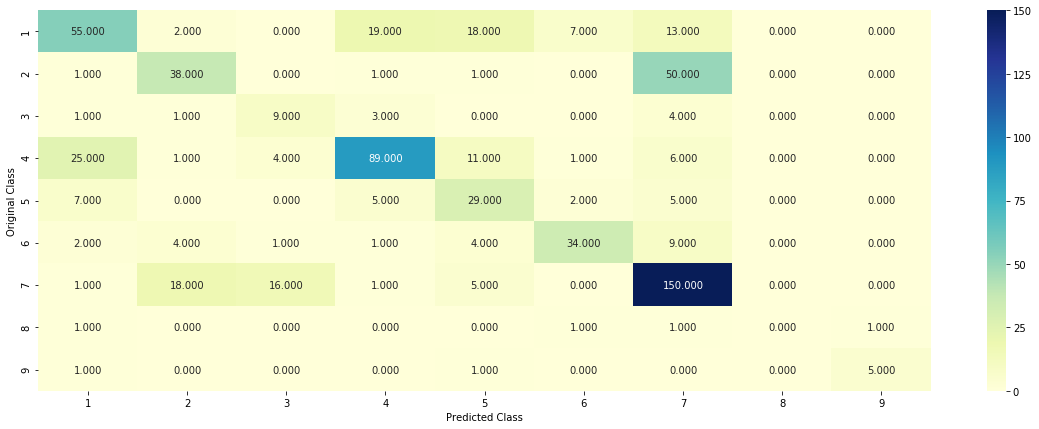

-------------------- Precision matrix (Columm Sum=1) --------------------


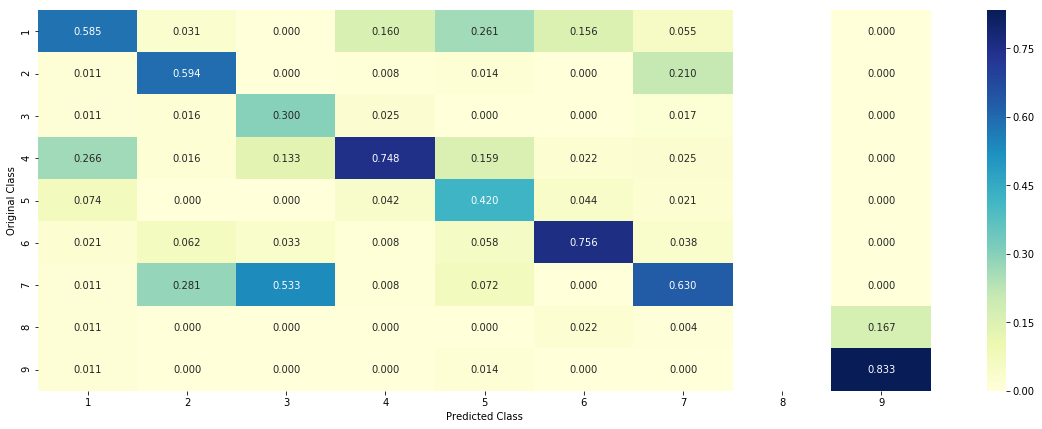

-------------------- Recall matrix (Row sum=1) --------------------


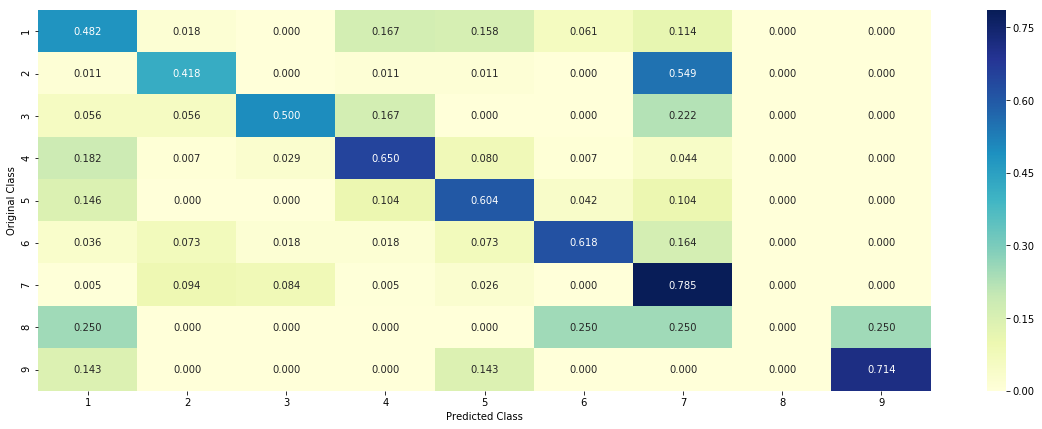

In [88]:
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(y_test, sig_clf.predict(test_x_onehotCoding)))
plot_confusion_matrix(y_test, sig_clf.predict(test_x_onehotCoding))

In [89]:
X_train['Class'].value_counts()

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

### Interpretibility of Naive bayes

In [90]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test.iloc[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0973 0.399  0.0119 0.1144 0.0448 0.0395 0.2847 0.0051 0.0032]]
Actual Class : 7
--------------------------------------------------
20 Text feature [identified] present in test data point [True]
26 Text feature [detection] present in test data point [True]
27 Text feature [including] present in test data point [True]
28 Text feature [another] present in test data point [True]
30 Text feature [confirmed] present in test data point [True]
37 Text feature [kinase] present in test data point [True]
38 Text feature [potential] present in test data point [True]
39 Text feature [identification] present in test data point [True]
40 Text feature [mutations] present in test data point [True]
41 Text feature [different] present in test data point [True]
44 Text feature [may] present in test data point [True]
45 Text feature [well] present in test data point [True]
46 Text feature [found] present in test data point [True]
49 Text feature [gene]

In [91]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test.iloc[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0913 0.0852 0.0112 0.1074 0.0423 0.0374 0.6174 0.0048 0.003 ]]
Actual Class : 7
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
17 Text feature [presence] present in test data point [True]
18 Text feature [activating] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [cells] present in test data point [True]
21 Text feature [well] present in test data point [True]
22 Text feature [contrast] present in test data point [True]
23 Text feature [recently] present in test data point [True]
24 Text feature [cell] present in test data point [True]
26 Text feature [inhibitor] present in test data point [True]
27 Text feature [expressing] present in test data point [True]
28 Text feature [previously] present in test data point [True]
29 Text feature [shown] present in test data point [True]
30 Text feature [activation]

## Logistic Regression  
#### (with over sampling - balancing all category samples)

In [92]:
alpha = [10**x for x in range(-6,3)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(train_x_onehotCoding, y_train)
    lr_predicted_y = sig_clf.predict_proba(cv_x_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, lr_predicted_y, labels=clf.classes_))
    print("for alpha : ", i, " log loss : ", log_loss(y_cv, lr_predicted_y))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning: invalid value enco

for alpha :  1e-06  log loss :  1.3449042598953413


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration

for alpha :  1e-05  log loss :  1.3624958230973243


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

for alpha :  0.0001  log loss :  1.258877014007145


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

for alpha :  0.001  log loss :  1.0693149405114568


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

for alpha :  0.01  log loss :  1.0824668171574725


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

for alpha :  0.1  log loss :  1.4402626906667024


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

for alpha :  1  log loss :  1.6966112134120943


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

for alpha :  10  log loss :  1.7302693193730947


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

for alpha :  100  log loss :  1.7326143162579373


In [93]:
best_alpha = alpha[np.argmin(cv_log_error_array)]

clf = SGDClassifier(alpha=best_alpha, loss='log', class_weight='balanced', random_state=42)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, 'sigmoid')
sig_clf.fit(train_x_onehotCoding, y_train)

train_y_predicted = sig_clf.predict_proba(train_x_onehotCoding)
print("train log loss : ", log_loss(y_train,train_y_predicted))

cv_y_predicted = sig_clf.predict_proba(cv_x_onehotCoding)
print("cv log loss : ", log_loss(y_cv,cv_y_predicted))

test_y_predicted = sig_clf.predict_proba(test_x_onehotCoding)
print("test log loss : ", log_loss(y_test,test_y_predicted))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

train log loss :  0.6150831125796328
cv log loss :  1.0514679175336625
test log loss :  1.123329813996234


Accuracy :  0.6270676691729323
-------------------- Confusion matrix --------------------


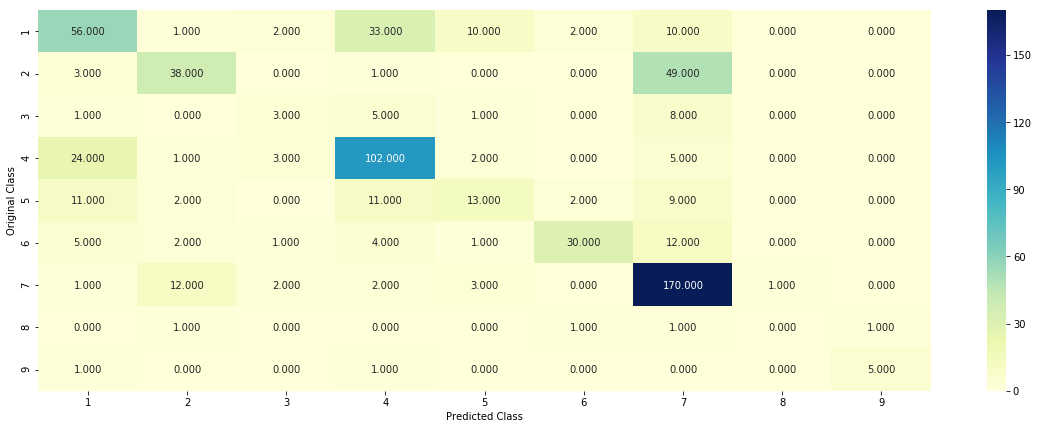

-------------------- Precision matrix (Columm Sum=1) --------------------


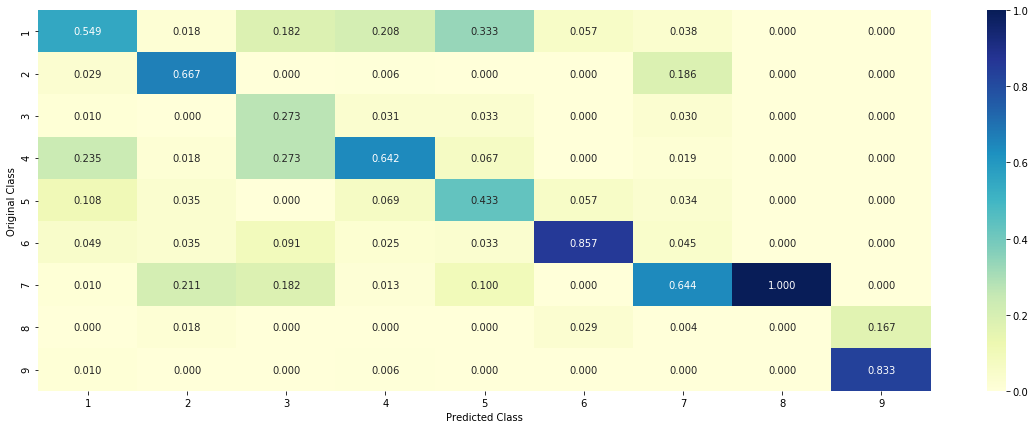

-------------------- Recall matrix (Row sum=1) --------------------


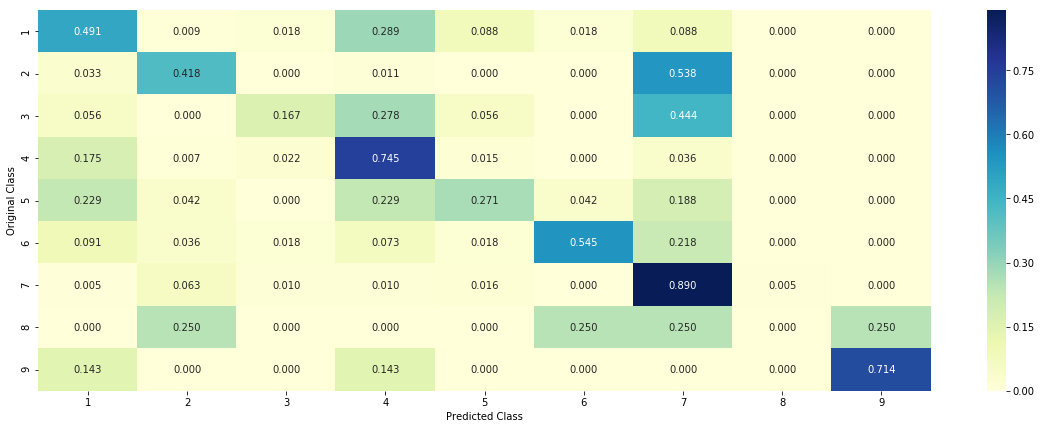

In [94]:
print("Accuracy : ", accuracy_score(y_test, sig_clf.predict(test_x_onehotCoding)))
plot_confusion_matrix(y_test, sig_clf.predict(test_x_onehotCoding))

#### Interpretability of LR

In [95]:
LR_Matrix = ['Logistic Regression', round(log_loss(y_train,train_y_predicted),2), round(log_loss(y_cv,cv_y_predicted),2),
             round(log_loss(y_test,test_y_predicted),2), round(accuracy_score(y_test, sig_clf.predict(test_x_onehotCoding)),2)]
EVAL_MATRIX = EVAL_MATRIX.append(pd.Series(LR_Matrix, index=EVAL_MATRIX.columns), ignore_index=True)
EVAL_MATRIX

,Classifier,Train log loss,CV log loss,Test log loss,Accuracy
0,Naive Bayes,0.85,1.25,1.29,0.62
1,Logistic Regression,0.62,1.05,1.12,0.63


## leaving interretability part... will do later

## Linear SVM

for C = 1e-05


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning: invalid value enco

Log Loss : 1.3621815835457145
for C = 0.0001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log Loss : 1.335001982207218
for C = 0.001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log Loss : 1.237668139821929
for C = 0.01


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log Loss : 1.0887086740351763
for C = 0.1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log Loss : 1.358090155986404
for C = 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log Loss : 1.7198740477077958
for C = 10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log Loss : 1.7331320677840425
for C = 100


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log Loss : 1.7332201484450136


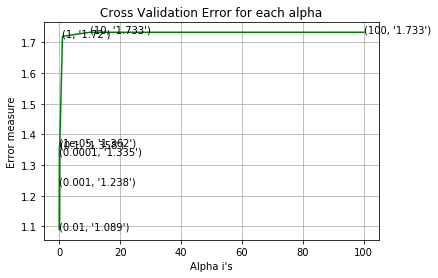

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

For values of best alpha =  0.01 The train log loss is: 0.7428206046481197
For values of best alpha =  0.01 The cross validation log loss is: 1.0887086740351763
For values of best alpha =  0.01 The test log loss is: 1.18581800200593


In [96]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

train_y_predicted = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, train_y_predicted, labels=clf.classes_, eps=1e-15))
cv_y_predicted = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, cv_y_predicted, labels=clf.classes_, eps=1e-15))
test_y_predicted = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, test_y_predicted, labels=clf.classes_, eps=1e-15))

In [97]:
LSVM_Matrix = ['Linear SVM', round(log_loss(y_train,train_y_predicted),2), round(log_loss(y_cv,cv_y_predicted),2),
             round(log_loss(y_test,test_y_predicted),2), round(accuracy_score(y_test, sig_clf.predict(test_x_onehotCoding)),2)]
EVAL_MATRIX = EVAL_MATRIX.append(pd.Series(LSVM_Matrix, index=EVAL_MATRIX.columns), ignore_index=True)
EVAL_MATRIX

,Classifier,Train log loss,CV log loss,Test log loss,Accuracy
0,Naive Bayes,0.85,1.25,1.29,0.62
1,Logistic Regression,0.62,1.05,1.12,0.63
2,Linear SVM,0.74,1.09,1.19,0.63


## Random Forest

#### with one hot encoding

In [98]:
from sklearn.ensemble import RandomForestClassifier

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))


for n_estimators = 100 and max depth =  5
Log Loss : 1.225758506230774
for n_estimators = 100 and max depth =  10
Log Loss : 1.168158760520705
for n_estimators = 200 and max depth =  5
Log Loss : 1.2172547149354687
for n_estimators = 200 and max depth =  10
Log Loss : 1.1574341578662433
for n_estimators = 500 and max depth =  5
Log Loss : 1.2101272051874115
for n_estimators = 500 and max depth =  10
Log Loss : 1.1512653680659286
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2078994546050899
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1493096825298692
for n_estimators = 2000 and max depth =  5
Log Loss : 1.207890336693852
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1477862139705137


In [99]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

train_y_predicted = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, train_y_predicted, labels=clf.classes_, eps=1e-15))
cv_y_predicted = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, cv_y_predicted, labels=clf.classes_, eps=1e-15))
test_y_predicted = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, test_y_predicted, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.7247807512691833
For values of best estimator =  2000 The cross validation log loss is: 1.1477862139705137
For values of best estimator =  2000 The test log loss is: 1.1802007383248418


In [100]:
RF1_Matrix = ['Random Forest with OHE', round(log_loss(y_train,train_y_predicted),2), round(log_loss(y_cv,cv_y_predicted),2),
             round(log_loss(y_test,test_y_predicted),2), round(accuracy_score(y_test, sig_clf.predict(test_x_onehotCoding)),2)]
EVAL_MATRIX = EVAL_MATRIX.append(pd.Series(RF1_Matrix, index=EVAL_MATRIX.columns), ignore_index=True)
EVAL_MATRIX

,Classifier,Train log loss,CV log loss,Test log loss,Accuracy
0,Naive Bayes,0.85,1.25,1.29,0.62
1,Logistic Regression,0.62,1.05,1.12,0.63
2,Linear SVM,0.74,1.09,1.19,0.63
3,Random Forest with OHE,0.72,1.15,1.18,0.61


#### RF with responce encoding

In [101]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

train_y_predicted = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, train_y_predicted, labels=clf.classes_, eps=1e-15))
cv_y_predicted = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, cv_y_predicted, labels=clf.classes_, eps=1e-15))
test_y_predicted = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, test_y_predicted, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 0.3368851240060163
for n_estimators = 10 and max depth =  3
Log Loss : 0.2692559192770228
for n_estimators = 10 and max depth =  5
Log Loss : 0.1287130479851119
for n_estimators = 10 and max depth =  10
Log Loss : 0.08683452353490334
for n_estimators = 50 and max depth =  2
Log Loss : 0.19489394644954253
for n_estimators = 50 and max depth =  3
Log Loss : 0.15364688775246607
for n_estimators = 50 and max depth =  5
Log Loss : 0.08655346719747783
for n_estimators = 50 and max depth =  10
Log Loss : 0.06526052026504654
for n_estimators = 100 and max depth =  2
Log Loss : 0.17136445790335358
for n_estimators = 100 and max depth =  3
Log Loss : 0.13422715347197406
for n_estimators = 100 and max depth =  5
Log Loss : 0.08476965064713382
for n_estimators = 100 and max depth =  10
Log Loss : 0.06342827039554663
for n_estimators = 200 and max depth =  2
Log Loss : 0.1552774175643336
for n_estimators = 200 and max depth =  3
Log Loss : 0.12103

In [102]:
RF2_Matrix = ['Random Forest with RE', round(log_loss(y_train,train_y_predicted),2), round(log_loss(y_cv,cv_y_predicted),2),
             round(log_loss(y_test,test_y_predicted),2), round(accuracy_score(y_test, sig_clf.predict(test_x_responseCoding)),2)]
EVAL_MATRIX = EVAL_MATRIX.append(pd.Series(RF2_Matrix, index=EVAL_MATRIX.columns), ignore_index=True)
EVAL_MATRIX

,Classifier,Train log loss,CV log loss,Test log loss,Accuracy
0,Naive Bayes,0.85,1.25,1.29,0.62
1,Logistic Regression,0.62,1.05,1.12,0.63
2,Linear SVM,0.74,1.09,1.19,0.63
3,Random Forest with OHE,0.72,1.15,1.18,0.61
4,Random Forest with RE,0.03,0.06,0.05,0.99


In [104]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


## Maximum Voting Model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\ProgramData\Anaconda3\lib\sit

Log loss (train) on the VotingClassifier : 0.9110773634913224
Log loss (CV) on the VotingClassifier : 1.1908131958667274
Log loss (test) on the VotingClassifier : 1.2363203079959266


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Number of missclassified point : 0.37142857142857144


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


-------------------- Confusion matrix --------------------


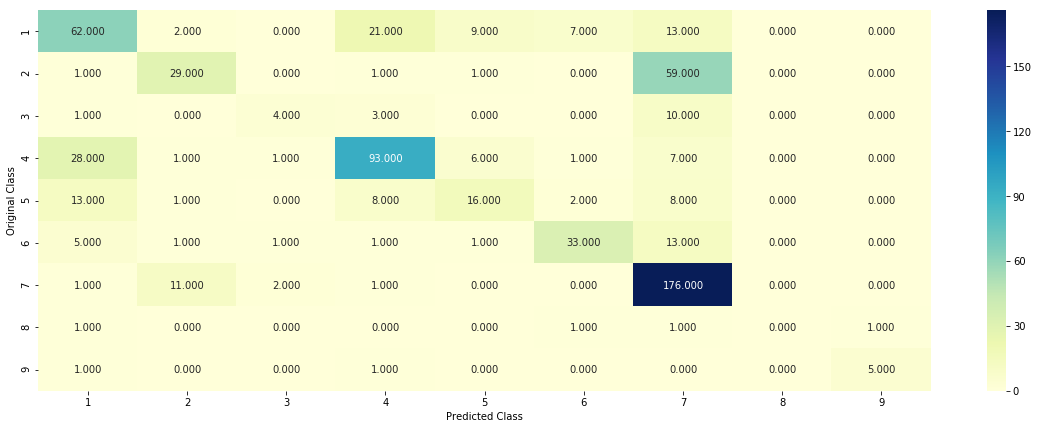

-------------------- Precision matrix (Columm Sum=1) --------------------


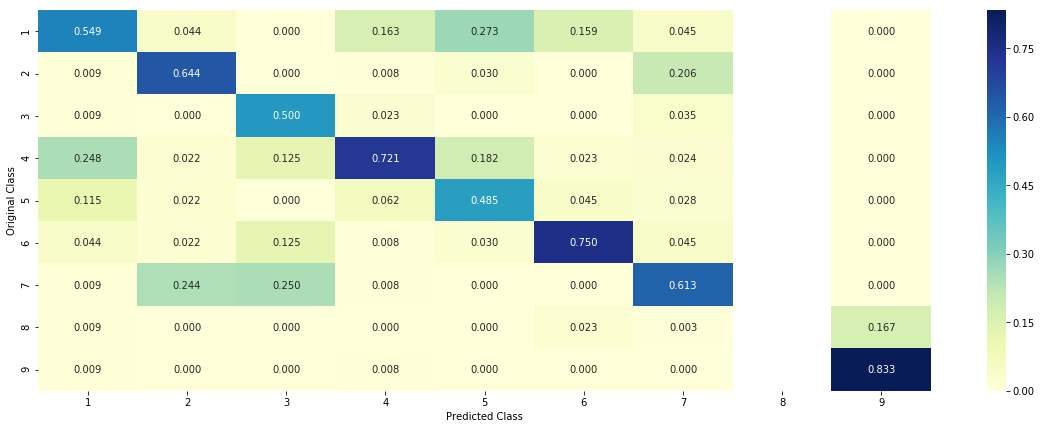

-------------------- Recall matrix (Row sum=1) --------------------


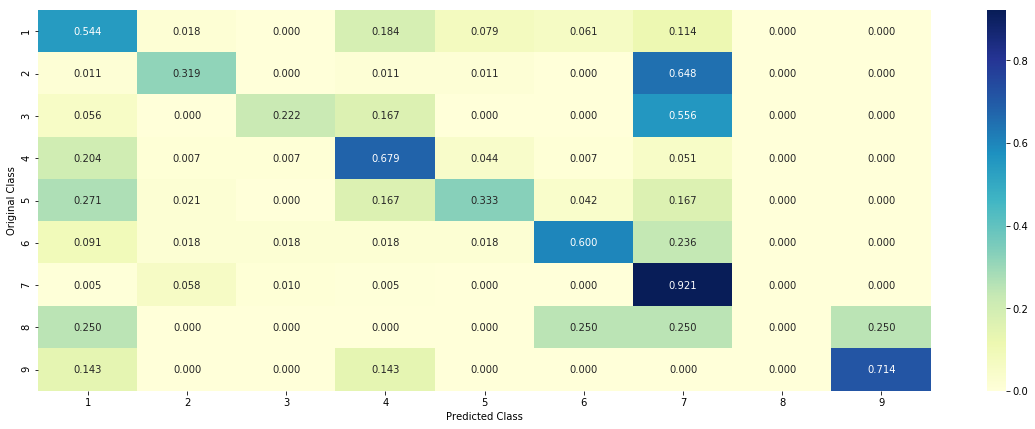

In [105]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

In [106]:
MV_Matrix = ['Maximum Voting Classifier-lr,svm,rf', 
             round(log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)),2), 
             round(log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)),2),
             round(log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)),2), 
             round(accuracy_score(y_test, vclf.predict(test_x_onehotCoding)),2)]
EVAL_MATRIX = EVAL_MATRIX.append(pd.Series(MV_Matrix, index=EVAL_MATRIX.columns), ignore_index=True)
EVAL_MATRIX

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Classifier,Train log loss,CV log loss,Test log loss,Accuracy
0,Naive Bayes,0.85,1.25,1.29,0.62
1,Logistic Regression,0.62,1.05,1.12,0.63
2,Linear SVM,0.74,1.09,1.19,0.63
3,Random Forest with OHE,0.72,1.15,1.18,0.61
4,Random Forest with RE,0.03,0.06,0.05,0.99
5,"Maximum Voting Classifier-lr,svm,rf",0.91,1.19,1.24,0.63


## DONE here :)